#### This Notebook Fits and Evaluates Naive Bayes for all three datasets

    Let's Load all the necessary modules:

In [58]:
import pandas as pd
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from normalizer import Normalizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from results import ModelEvaluation
from joblib import dump

    Lets write some macros for I/O

In [94]:
def print_info(msg):
    print("[INFO] "+str(msg))

def print_err(msg):
    print("[ERR] "+str(msg))

def get_balanced_sample(data_frame, n):
    # Separate the DataFrame into two DataFrames based on class
    class_0_df = data_frame[data_frame['label'] == 0]
    class_1_df = data_frame[data_frame['label'] == 1]

    # Calculate the number of samples for each class in the balanced sample
    n_per_class = n // 2  # Divide by 2 to get an equal number of samples for each class

    # Sample n_per_class random rows from each class
    balanced_sample_class_0 = class_0_df.sample(n=n_per_class, random_state=42)
    balanced_sample_class_1 = class_1_df.sample(n=n_per_class, random_state=42)

    # Combine the balanced samples into a single DataFrame
    balanced_sample = pd.concat([balanced_sample_class_0, balanced_sample_class_1])

    # Shuffle the balanced sample
    balanced_sample = balanced_sample.sample(frac=1, random_state=42).reset_index(drop=True)

    return balanced_sample


def get_combined_datasets(data_frame_one, data_frame_two):
    combined_df = pd.concat([data_frame_one, data_frame_two])

# Step 2: Shuffle the combined DataFrame
    shuffled_df = combined_df.sample(frac=1).reset_index(drop=True)
    return shuffled_df

    Let's initialize some objects that we need through-out

In [60]:
normalizer = Normalizer()
results = ModelEvaluation()
SAMPLE_SIZE = 20000
print_info("OBJECTS INIT DONE.")

[INFO] OBJECTS INIT DONE.


    Let's load all the datasets:

In [61]:
TwitterData = pd.read_csv("../dataset/TwitterDataset.txt", sep="\t")
print_info("Twitter Dataset is now loaded.")
NewsHeadlinesData =  pd.read_json("../dataset/Sarcasm_Headlines_Dataset.json", lines = True)
print_info("NewHeadlines Dataset is now loaded.")
RedditData = pd.read_csv("../datasets/sarcasm_subset.csv")
print_info("Reddit Dataset is now loaded.")


[INFO] Twitter Dataset is now loaded.
[INFO] NewHeadlines Dataset is now loaded.


[INFO] Reddit Dataset is now loaded.


In [62]:
print_info("Dropping irrelevant columns from Reddit Data")
RedditData = RedditData.drop(columns=["author", "subreddit", "score", "ups", "downs", "date", "created_utc"])
print_info("Irrelevant columns have been dropped")
print_info("There are null columns lets drop them.")
RedditData = RedditData.dropna()
print_info("Null values have been dropped.")
print_info("There are two columns for text, combining them into one")
RedditData["text"] = RedditData["comment"] + RedditData["parent_comment"]
print_info("Two fields of Reddit data 'comment' and 'parent_comment' have been combined into 'text'")
RedditData = RedditData.drop(columns=["comment", "parent_comment"])
print_info("Selecting sub sample.")
RedditData = get_balanced_sample(RedditData, SAMPLE_SIZE)
RedditData.info()

[INFO] Dropping irrelevant columns from Reddit Data
[INFO] Irrelevant columns have been dropped
[INFO] There are null columns lets drop them.
[INFO] Null values have been dropped.
[INFO] There are two columns for text, combining them into one
[INFO] Two fields of Reddit data 'comment' and 'parent_comment' have been combined into 'text'
[INFO] Selecting sub sample.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   20000 non-null  int64 
 1   text    20000 non-null  object
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


    Let's explore each of these Datasets:

In [63]:
print_info("Changing feature names for data compatibility wihtin News Headlines Dataset")
NewsHeadlinesData.columns =["link", "text", "label"]
print_info("The Features have been renamed.")
print_info("Dropping irrelevant features from this dataset")
NewsHeadlinesData = NewsHeadlinesData.drop(columns=["link"])
print_info("NewsHeadlinesData.Link has been dropped.")
print_info("Selecting samples, by addressing class imbalance as well")
NewsHeadlinesData = get_balanced_sample(NewsHeadlinesData, SAMPLE_SIZE)
print_info("The following is information related to NewsHeadlines:")
print_info("News Headlines Dataset information:\n")
NewsHeadlinesData.info()


[INFO] Changing feature names for data compatibility wihtin News Headlines Dataset
[INFO] The Features have been renamed.
[INFO] Dropping irrelevant features from this dataset
[INFO] NewsHeadlinesData.Link has been dropped.
[INFO] Selecting samples, by addressing class imbalance as well
[INFO] The following is information related to NewsHeadlines:
[INFO] News Headlines Dataset information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20000 non-null  object
 1   label   20000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


In [64]:

print_info("The Twitter set does not have any column names, adding same feature names as NewsHeadlinesDataset")
TwitterData.columns = ["sample", "label", "text"]
print_info("Feature names have been updated.")
print_info("Dropping irrelevant features")
TwitterData = TwitterData.drop(columns= ["sample"])
print_info("Irrelevant features have been dropped")
print_info("Selecting samples, by addressing class imbalance as well")
TwitterData = get_balanced_sample(TwitterData, SAMPLE_SIZE)
print("Twitter Dataset information: \n")
TwitterData.info()

[INFO] The Twitter set does not have any column names, adding same feature names as NewsHeadlinesDataset
[INFO] Feature names have been updated.
[INFO] Dropping irrelevant features
[INFO] Irrelevant features have been dropped
[INFO] Selecting samples, by addressing class imbalance as well
Twitter Dataset information: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   20000 non-null  int64 
 1   text    20000 non-null  object
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


# 1. Naive Bayes for News Headlines Dataset:

    Get the sparse matrix for this text:

In [65]:
news_matrix = normalizer.vectorize(pd.DataFrame({"text": NewsHeadlinesData["text"].astype("str")}))
print_info("Here's the sprase matrix info: ")
news_matrix

[INFO] Trying to create a sparse matrix for text, using an instance of TfIdf_vectorizer
[INFO] Extracting columns containing text from dataframe.
[INFO] Successfully extracted text columns from the dataset.
[INFO] Applying Normalization over text:
[INFO]       - Converting Text into lower case for caseconsistency.
[INFO]       - Extracting only words containing alphabets.
[INFO] Text Normalization is now complete.
[INFO] Fitting the vecotirzer to given text.
[INFO] Transforming the text into a sparse matrix.
[INFO] Sparse Matrix has been successfully created over the text given as input.
[INFO] Here's the sprase matrix info: 


<20000x22618 sparse matrix of type '<class 'numpy.float64'>'
	with 191328 stored elements in Compressed Sparse Row format>

    Hold out data for testing:

In [66]:
print_info("Attempting to split data into train and test sets.")
y_news = NewsHeadlinesData["label"].astype("int")
X_news = news_matrix.toarray()
X_news_train, X_news_test, y_news_train, y_news_test = train_test_split(X_news, y_news, test_size=0.20, random_state=42, stratify=y_news)
print_info("Subsets created successfully.")

[INFO] Attempting to split data into train and test sets.
[INFO] Subsets created successfully.


    Lets fit a NB for this set:

In [67]:
print_info("Creating a new instance of Naive Bayes for News Headlines")
NB_news = MultinomialNB()
print_info("Fitting a Naive Bayes to this")
NB_news.fit(X_news_train, y_news_train)
print_info("DONE.")

[INFO] Creating a new instance of Naive Bayes for News Headlines
[INFO] Fitting a Naive Bayes to this
[INFO] DONE.


    Let's test the Naive Bayes for News Headlines:

In [68]:
print_info("Asking the Naive Bayes trained on News Headlines to make some Predictions")
y_news_pred = NB_news.predict(X_news_test)
print_info("Predictions have been obtained.")


[INFO] Asking the Naive Bayes trained on News Headlines to make some Predictions
[INFO] Predictions have been obtained.


    Let's look at the Performance for Naive Bayes on News Headlines:

In [69]:
print_info("The following are the evaluation metrics for NB over news headlines:")
results.classification_report(y_news_test, y_news_pred)

[INFO] The following are the evaluation metrics for NB over news headlines:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      2000
           1       0.86      0.81      0.83      2000

    accuracy                           0.84      4000
   macro avg       0.84      0.84      0.84      4000
weighted avg       0.84      0.84      0.84      4000



    Confusion Matrix for NB over NewsHeadlines Dataset:

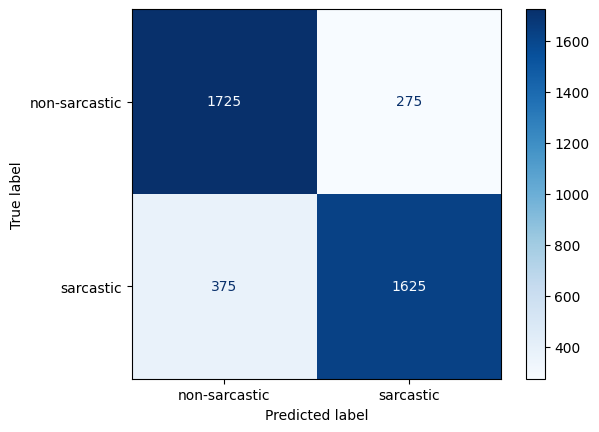

In [70]:
results.get_cm(y_true=y_news_test, y_pred=y_news_pred)

    Let's Look at current ROC_AUC and use best threshold for prediction of values.

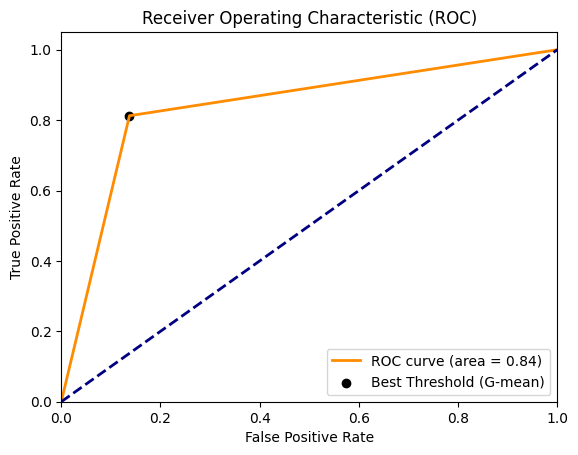

Best Threshold=1.0000


In [71]:
y_proba_news = NB_news.predict_proba(X_news_test)[:,1]
news_threshold = results.get_roc(y_news_test, y_news_pred)

The best threshold obtained is not useful for being applied lets move on.

In [72]:
results.cross_validation_score(NB_news, X_news, y_news)

Cross-validation scores for each fold: [0.8255  0.83275 0.82975 0.83125 0.84   ]
Mean score: 0.83185
Standard Deviation of the scores: 0.004739725730461612


array([0.8255 , 0.83275, 0.82975, 0.83125, 0.84   ])

    Save this Model:

In [73]:
dump(NB_news, "../FinalModels/models/NewsHeadlines_NaiveBayes.joblib")

['../FinalModels/models/NewsHeadlines_NaiveBayes.joblib']

# 2. Naive Bayes for Twitter Set

    Get the matrix for the Twtter set first

In [74]:
twitter_matrix = normalizer.vectorize(pd.DataFrame({"text": TwitterData["text"].astype("str")}))
print_info("Here's the sprase matrix info: ")
twitter_matrix

[INFO] Trying to create a sparse matrix for text, using an instance of TfIdf_vectorizer
[INFO] Extracting columns containing text from dataframe.
[INFO] Successfully extracted text columns from the dataset.
[INFO] Applying Normalization over text:
[INFO]       - Converting Text into lower case for caseconsistency.
[INFO]       - Extracting only words containing alphabets.
[INFO] Text Normalization is now complete.
[INFO] Fitting the vecotirzer to given text.
[INFO] Transforming the text into a sparse matrix.
[INFO] Sparse Matrix has been successfully created over the text given as input.
[INFO] Here's the sprase matrix info: 


<20000x22191 sparse matrix of type '<class 'numpy.float64'>'
	with 276871 stored elements in Compressed Sparse Row format>

    Hold out some data for testing:

In [75]:
print_info("Attempting to split data into train and test sets.")
y_twitter = TwitterData["label"].astype("int")
X_twitter = twitter_matrix
X_twitter_train, X_twitter_test, y_twitter_train, y_twitter_test = train_test_split(X_twitter, y_twitter, test_size=0.20, random_state=42, stratify=y_twitter)
print_info("Subsets created successfully.")

[INFO] Attempting to split data into train and test sets.
[INFO] Subsets created successfully.


    Let's now Fit a Naive Bayes for this..

In [76]:
print_info("Attempting to Fit a Naive Bayes for Twitter dataset: ")
NB_twitter = MultinomialNB()
NB_twitter = NB_twitter.fit(X_twitter_train, y_twitter_train)
print_info("The Naive Bayes instance is now ready for twitter set.")

[INFO] Attempting to Fit a Naive Bayes for Twitter dataset: 
[INFO] The Naive Bayes instance is now ready for twitter set.


    Lets test the Naive Bayes model over Twitter dataset.

In [77]:
print_info("Asking the Naive Bayes trained on Twitter Dataset to make some Predictions")
y_twitter_pred = NB_twitter.predict(X_twitter_test)
print_info("Predictions have been obtained.")


[INFO] Asking the Naive Bayes trained on Twitter Dataset to make some Predictions
[INFO] Predictions have been obtained.


    Lets look at evaluation Metrics of how this model performs:

In [78]:
print_info("The following are the evaluation metrics for NB over TwitterSET:")
results.classification_report(y_twitter_test, y_twitter_pred)

[INFO] The following are the evaluation metrics for NB over TwitterSET:
              precision    recall  f1-score   support

           0       0.83      0.67      0.74      2000
           1       0.73      0.86      0.79      2000

    accuracy                           0.77      4000
   macro avg       0.78      0.77      0.77      4000
weighted avg       0.78      0.77      0.77      4000



    Well the acc went down pretty well. Lets look at the Confusion Matrix:

[INFO] The following the confusion matirx for Naive Bayes over Twitter Test Set:


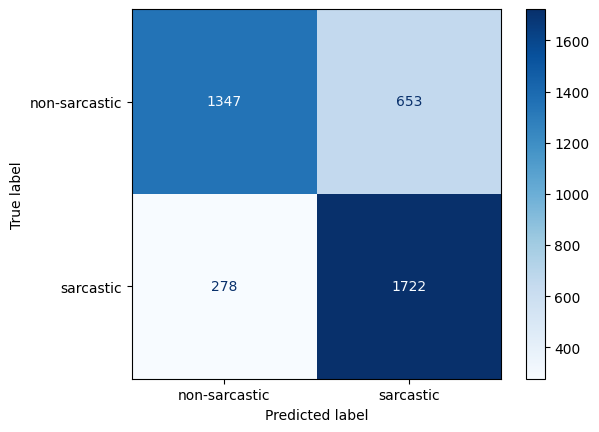

In [79]:
print_info("The following the confusion matirx for Naive Bayes over Twitter Test Set:")
results.get_cm(y_twitter_test, y_twitter_pred)

    Let's look at it's ROC_AUC curve
    

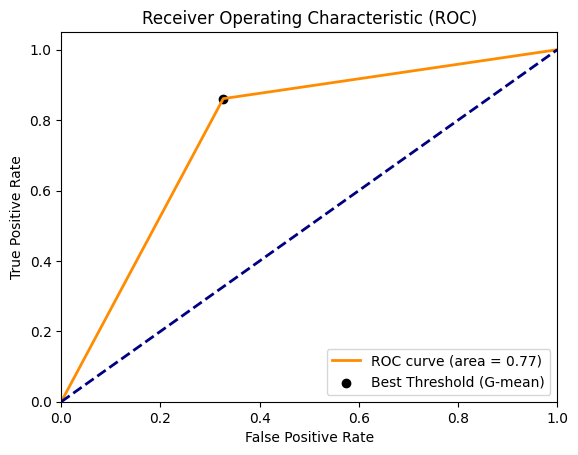

Best Threshold=1.0000


In [80]:
y_proba_twitter = NB_twitter.predict_proba(X_twitter_test)[:,1]
twitter_threshold = results.get_roc(y_twitter_test, y_twitter_pred)

    Let's perform Cross Validation to validate the model's metrics:

In [81]:
results.cross_validation_score(NB_twitter, X_twitter, y_twitter)

Cross-validation scores for each fold: [0.76875 0.7505  0.74375 0.75475 0.75   ]
Mean score: 0.7535499999999999
Standard Deviation of the scores: 0.008371678445807643


array([0.76875, 0.7505 , 0.74375, 0.75475, 0.75   ])

    Lets save the model

In [82]:
dump(NB_twitter, "../FinalModels/models/Twitter_NaiveBayes.joblib")

['../FinalModels/models/Twitter_NaiveBayes.joblib']

# 3. Naive Bayes for Reddit Data

    Get the matrix

In [83]:
reddit_matrix = normalizer.vectorize(pd.DataFrame({"text": RedditData["text"].astype("str")}))
print_info("Here's the sprase matrix info: ")
reddit_matrix

[INFO] Trying to create a sparse matrix for text, using an instance of TfIdf_vectorizer
[INFO] Extracting columns containing text from dataframe.
[INFO] Successfully extracted text columns from the dataset.
[INFO] Applying Normalization over text:
[INFO]       - Converting Text into lower case for caseconsistency.
[INFO]       - Extracting only words containing alphabets.
[INFO] Text Normalization is now complete.
[INFO] Fitting the vecotirzer to given text.
[INFO] Transforming the text into a sparse matrix.
[INFO] Sparse Matrix has been successfully created over the text given as input.
[INFO] Here's the sprase matrix info: 


<20000x41893 sparse matrix of type '<class 'numpy.float64'>'
	with 533494 stored elements in Compressed Sparse Row format>

    Hold the data out

In [84]:
print_info("Attempting to split data into train and test sets.")
y_reddit = RedditData["label"].astype("int")
X_reddit = reddit_matrix
X_reddit_train, X_reddit_test, y_reddit_train, y_reddit_test = train_test_split(X_reddit, y_reddit, test_size=0.20, random_state=42, stratify=y_reddit)
print_info("Subsets created successfully.")

[INFO] Attempting to split data into train and test sets.
[INFO] Subsets created successfully.


    Let's now Fit a Naive Bayes for this..

In [85]:
print_info("Attempting to Fit a Naive Bayes for Reddit dataset: ")
NB_reddit = MultinomialNB()
NB_reddit = NB_twitter.fit(X_reddit_train, y_reddit_train)
print_info("The Naive Bayes instance is now ready for Reddit set.")

[INFO] Attempting to Fit a Naive Bayes for Reddit dataset: 
[INFO] The Naive Bayes instance is now ready for Reddit set.


    Lets test the Naive Bayes model over Reddit dataset.

In [86]:
print_info("Asking the Naive Bayes trained on Reddit Dataset to make some Predictions")
y_reddit_pred = NB_reddit.predict(X_reddit_test)
print_info("Predictions have been obtained.")


[INFO] Asking the Naive Bayes trained on Reddit Dataset to make some Predictions
[INFO] Predictions have been obtained.


    Lets look at evaluation Metrics of how this model performs:

In [87]:
print_info("The following are the evaluation metrics for NB over Reddit:")
results.classification_report(y_reddit_test, y_reddit_pred)

[INFO] The following are the evaluation metrics for NB over Reddit:
              precision    recall  f1-score   support

           0       0.61      0.54      0.57      2000
           1       0.59      0.66      0.62      2000

    accuracy                           0.60      4000
   macro avg       0.60      0.60      0.60      4000
weighted avg       0.60      0.60      0.60      4000



    Let's look at the Confusion Matrix:

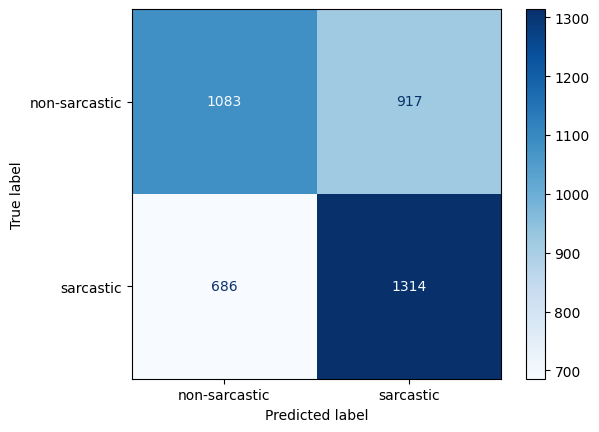

In [88]:
results.get_cm(y_reddit_test, y_reddit_pred)

    Let's look at ROC_AUC

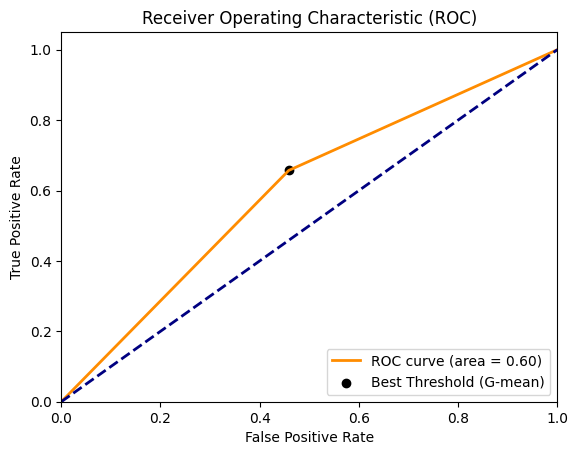

Best Threshold=1.0000


In [89]:
y_proba_reddit = NB_reddit.predict_proba(X_reddit_test)[:,1]
reddit_threshold = results.get_roc(y_reddit_test, y_reddit_pred)

    Let's cross validate these scores:

In [90]:
results.cross_validation_score(NB_reddit, X_reddit, y_reddit)

Cross-validation scores for each fold: [0.6015  0.5915  0.60375 0.611   0.6025 ]
Mean score: 0.60205
Standard Deviation of the scores: 0.006241794613730882


array([0.6015 , 0.5915 , 0.60375, 0.611  , 0.6025 ])

    Let's save this model for persistence:

In [91]:
dump(NB_reddit, "../FinalModels/models/Reddit_NaiveBayes.joblib")

['../FinalModels/models/Reddit_NaiveBayes.joblib']

    Let's save these datasets:

In [92]:
NewsHeadlinesData.to_csv("../FinalModels/datasets/NewsHeadlines.csv")
RedditData.to_csv("../FinalModels/datasets/RedditData.csv")
TwitterData.to_csv("../FinalModels/datasets/TwitterData.csv")

# Combining Datasets

### Twitter + News Headlines Datasets:

In [109]:
print_info("Combining Twitter and News headlines dataset to test it.")
Twitter_News_data = get_combined_datasets(NewsHeadlinesData, TwitterData)
print_info("They have been combined here's the information: ")
Twitter_News_data.info()

[INFO] Combining Twitter and News headlines dataset to test it.
[INFO] They have been combined here's the information: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


    Lets get the matrix for this:

In [110]:
tn_matrix = normalizer.vectorize(pd.DataFrame({"text": Twitter_News_data["text"].astype("str")}))
tn_matrix

[INFO] Trying to create a sparse matrix for text, using an instance of TfIdf_vectorizer
[INFO] Extracting columns containing text from dataframe.
[INFO] Successfully extracted text columns from the dataset.
[INFO] Applying Normalization over text:
[INFO]       - Converting Text into lower case for caseconsistency.
[INFO]       - Extracting only words containing alphabets.
[INFO] Text Normalization is now complete.
[INFO] Fitting the vecotirzer to given text.
[INFO] Transforming the text into a sparse matrix.
[INFO] Sparse Matrix has been successfully created over the text given as input.


<40000x35137 sparse matrix of type '<class 'numpy.float64'>'
	with 468199 stored elements in Compressed Sparse Row format>

    Let's split this into test, and train sets.

In [117]:
print_info("Attempting to split data into train and test sets.")
y_tn = Twitter_News_data["label"].astype("int")
X_tn = tn_matrix
X_tn_train, X_tn_test, y_tn_train, y_tn_test = train_test_split(X_tn, y_tn, test_size=0.25, random_state=42, stratify=y_tn)
print_info("Subsets created successfully.")

[INFO] Attempting to split data into train and test sets.
[INFO] Subsets created successfully.


    Let's fit Naive bayes over this data:

In [118]:
NB_tn = MultinomialNB()
NB_tn = NB_tn.fit(X_tn_train, y_tn_train)


In [119]:
y_tn_pred = NB_tn.predict(X_tn_test)
results.classification_report(y_tn_test, y_tn_pred)

              precision    recall  f1-score   support

           0       0.78      0.72      0.75      5000
           1       0.74      0.80      0.77      5000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



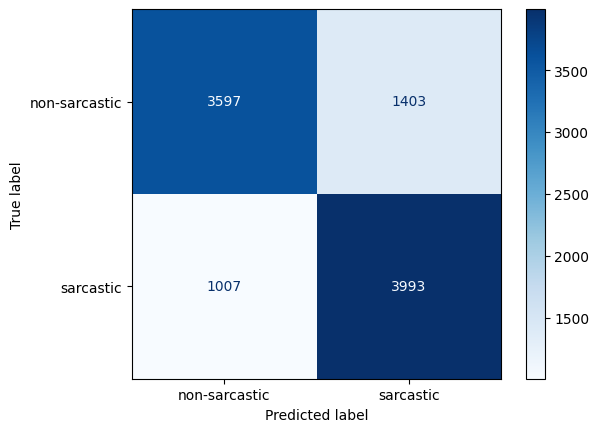

In [120]:
results.get_cm(y_tn_test, y_tn_pred)

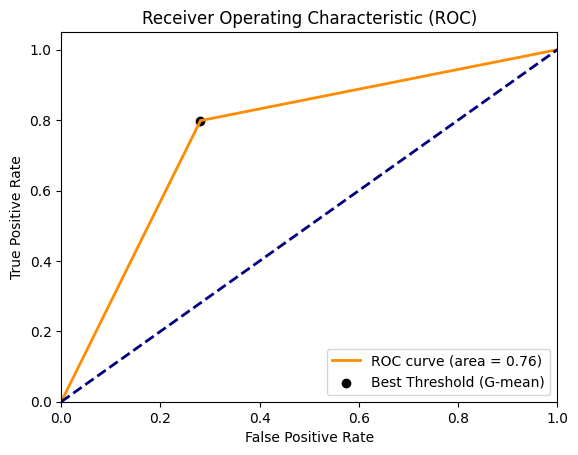

Best Threshold=1.0000


In [121]:
y_proba_tn = NB_tn.predict_proba(X_tn_test)[:,1]
tn_threshold = results.get_roc(y_tn_test, y_tn_pred)

In [128]:
results.cross_validation_score(NB_tn, X_tn, y_tn)

Cross-validation scores for each fold: [0.764375 0.761    0.763625 0.757125 0.755   ]
Mean score: 0.7602249999999999
Standard Deviation of the scores: 0.0036412566512125967


array([0.764375, 0.761   , 0.763625, 0.757125, 0.755   ])

    Saving this dataset and model.

In [133]:
dump(NB_tn, "../FinalModels/models/TwitterNews_NaiveBayes.joblib")
Twitter_News_data.to_csv("../FinalModels/datasets/TwitterNews.csv")

# Now lets combine all three sets:

In [131]:
combined_set = get_combined_datasets(Twitter_News_data, NewsHeadlinesData)
combined_matrix = normalizer.vectorize(pd.DataFrame({"text": combined_set["text"].astype("str")}))

[INFO] Trying to create a sparse matrix for text, using an instance of TfIdf_vectorizer
[INFO] Extracting columns containing text from dataframe.
[INFO] Successfully extracted text columns from the dataset.
[INFO] Applying Normalization over text:
[INFO]       - Converting Text into lower case for caseconsistency.
[INFO]       - Extracting only words containing alphabets.
[INFO] Text Normalization is now complete.
[INFO] Fitting the vecotirzer to given text.
[INFO] Transforming the text into a sparse matrix.
[INFO] Sparse Matrix has been successfully created over the text given as input.


In [136]:
print_info("Attempting to split data into train and test sets.")
y_combined = combined_set["label"].astype("int")
X_combined = combined_matrix
X_combined_train, X_combined_test, y_combined_train, y_combined_test = train_test_split(X_combined, y_combined, test_size=0.25, random_state=42, stratify=y_combined)
print_info("Subsets created successfully.")

[INFO] Attempting to split data into train and test sets.
[INFO] Subsets created successfully.


In [138]:
NB_combined = MultinomialNB()
NB_combined = NB_tn.fit(X_combined_train, y_combined_train)


In [139]:
y_combined_pred = NB_combined.predict(X_combined_test)
results.classification_report(y_combined_test, y_combined_pred)

              precision    recall  f1-score   support

           0       0.83      0.80      0.82      7500
           1       0.81      0.84      0.82      7500

    accuracy                           0.82     15000
   macro avg       0.82      0.82      0.82     15000
weighted avg       0.82      0.82      0.82     15000



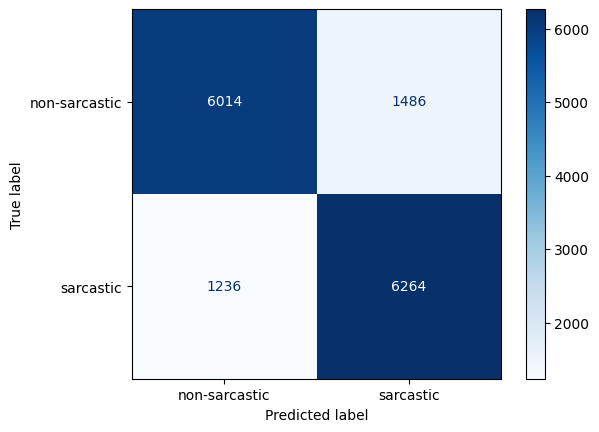

In [140]:
results.get_cm(y_combined_test, y_combined_pred)

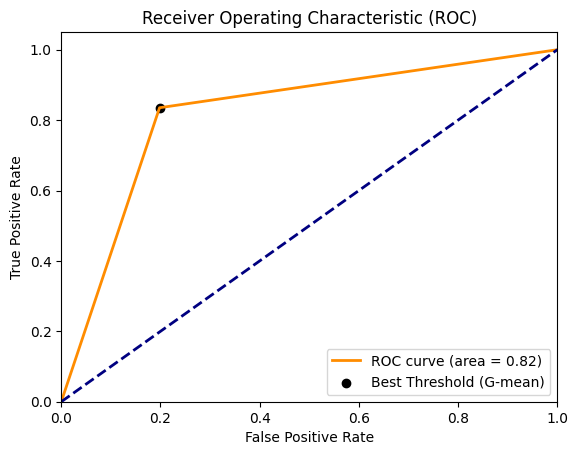

Best Threshold=1.0000


In [141]:
y_proba_combined = NB_combined.predict_proba(X_combined_test)[:,1]
combined_threshold = results.get_roc(y_combined_test, y_combined_pred)

In [142]:
dump(NB_combined, "../FinalModels/models/EntireSet_NaiveBayes")
combined_set.to_csv("../FinalModels/datasets/Twitter_News_Reddit.csv")